## <font style="font-family:roboto;color:#455e6c"> Multiple Rolling Simulation with DAMASK </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> StahlDigital Tutorial: Creating and Running Simulations for Steel Development </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 25 April 2024 </font>
</div>

In this notebook, we will use `pyiron` to setup and run a workflow for multiple rolling simulation of steel with the continuum code [DAMASK](https://damask.mpie.de/release/). A damask simulation requires material specific information (`Elastic` and `Plastic` parameters of the material). We will show, how we can get these parameters from a `Tensile Test Experiment` data using [DSMS](https://stahldigital.materials-data.space/) and run damask simulation with these parameters.

### <font style="font-family:roboto;color:#455e6c"> Import necessary libraries </font>  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from pyiron import Project
from damask import Rotation
from dsms import DSMS, KItem
from getpass import getpass
from urllib.parse import urljoin
from data2rdf import AnnotationPipeline, Parser 

In [2]:
# Unit conversion factors: from megapascal(MPa) and gegapascal(GPa) to pascal(Pa)  
MPa_to_Pa = 1e+6
GPa_to_Pa = 1e+9

#### <font style="font-family:roboto;color:#455e6c"> Create a pyiron project </font>  

In [3]:
pr = Project('damask_rolling_simulation')

### <font style="font-family:roboto;color:#455e6c"> Running a multiple rolling simulation with DAMASK </font>

Suppose your colluge performed a nice tensile test experiment and uploaded the data, the fitted elasticity parameters, and phenopowerlaw parameters required for damask simulation into the `DSMS`. Now, we will show how you can get the required parameters from dsms and run your `DAMASK` simulation with it.

First, we will write two python functions to get the required data from DSMS
- A python function to get experimental elastic parameters 
- A python function to get experimental plastic parameters

In [4]:
# A python function to get experimental elastic parameters from dsms
def get_elasticity_data_from_dsms(item):
    elasticity_data = {"type": "Hooke",
                       "C_11": item.custom_properties.ElasticConstantC11.convert_to('Pa'),
                       "C_12": item.custom_properties.ElasticConstantC12.convert_to('Pa'),
                       "C_44": item.custom_properties.ElasticConstantC44.convert_to('Pa')
                      }
    return elasticity_data

In [5]:
# A python function to get experimental plastic parameters from dsms
def get_plasticity_data_from_dsms(item):
    plasticity_data = {"type": "phenopowerlaw",
                       "references": ["https://doi.org/10.1016/j.actamat.2014.07.071",
                                       "https://doi.org/10.1007/BF02900224"],
                       "output": ["xi_sl", "gamma_sl"],
                       "N_sl": item.hdf5.NumberSlipSystems.get(),
                       "dot_gamma_0_sl": item.hdf5.ReferenceShearRate.get(),
                       "n_sl": item.hdf5.Inv_ShearRateSensitivity.get(),
                       "a_sl": item.hdf5.HardeningExponent.get(),
                       "xi_0_sl": item.hdf5.InitialCriticalStrength.convert_to('Pa'),
                       "xi_inf_sl": item.hdf5.FinalCriticalStrength.convert_to('Pa'),
                       "h_0_sl_sl": item.hdf5.InitialHardening.convert_to('Pa'),
                       "h_sl_sl": [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4, 1.4,
                                    1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
                                    1.4,1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
                       }
    return plasticity_data

Now, we have to connect to `dsms`. For the next step you need your dsms `username` and `password`. If you don't have a dsms account, please look [here](https://stahldigital.materials-data.space/support) for help.

In case you don't have a `dsms` account, uncomment the following cell and skip all steps related to `dsms`

In [6]:
# After executing this cell, you have to enter your dsms username 
username = getpass()

 ········


In [7]:
# After executing this cell, you have to enter your dsms password
password = getpass()

 ········


In [8]:
# Now we will connect to dsms
dsms = DSMS(host_url="https://stahldigital.materials-data.space",
            username=username,
            password=password)

In [9]:
# Search for our data item using unique KItem UUID
# input_kitem_id = 'ff8ee824-cef6-465c-84af-4d332e73ac64' # dsms KItem UUID for our dataset
input_kitem_id = '1ba3712b-68f2-4f2f-89d9-e0b3e4823d48' # New KItem
item = dsms[input_kitem_id]

In [10]:
# Run the functions defined above to get experimental elasticity and plasticity data from dsms
elasticity_data = get_elasticity_data_from_dsms(item)
plasticity_data = get_plasticity_data_from_dsms(item)

Now, we will use these data obtained from `dsms` to create a `damask` simulation.

Again, we start by creating a pyiron job `job_rolling`. For multiple rolling, we need to use the pyiron class `ROLLING`

In [11]:
job_rolling = pr.create.job.ROLLING('damask_job')

Now, we use pyiron functinalities to configure our simulation with parameters obtained from `dsms`

In [12]:
# Elastic paramaters of the material
elasticity = pr.continuum.damask.Elasticity(**elasticity_data)

In [13]:
# Plastic parameters of the material
plasticity = pr.continuum.damask.Plasticity(**plasticity_data)  

In [14]:
# Define phase of the material
phase = pr.continuum.damask.Phase(composition ='DX56D',
                                  lattice = 'cI',
                                  output_list = ['F', 'P'],
                                  elasticity = elasticity, 
                                  plasticity = plasticity
                                 )

In [15]:
# Define homogenization
homogenization = pr.continuum.damask.Homogenization(method='SX',
                                                    parameters={'N_constituents': 1,
                                                                "mechanical": {"type": "pass"}})

In [16]:
# Defines the number of grains and grids
grains = 60
grids = 16 

In [17]:
# Define homogenization
rotation = pr.continuum.damask.Rotation(Rotation.from_random,
                                        grains)

In [18]:
# Materialpoint configuration
material = pr.continuum.damask.Material([rotation],
                                        ['DX56D'],
                                        phase,
                                        homogenization)

In [19]:
# Define grid
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(spatial_discretization=grids,
                                                         num_grains=grains,
                                                         box_size=1.6e-5)

In [20]:
# Assign the material and grid to the damask job
job_rolling.material = material
job_rolling.grid = grid

#### <font style="font-family:roboto;color:#455e6c"> Now we are ready to start rolling simulation </font>

Let's do the first rolling

In [21]:
# Define parameters for first rolling
reduction_height = 0.05
reduction_speed = 5.0e-2
reduction_outputs = 250
regrid_flag = False
damask_exe = ''

In [22]:
# Run first rolling simulation
job_rolling.executeRolling(reduction_height,
                           reduction_speed,
                           reduction_outputs,
                           regrid_flag,
                           damask_exe
                           )

working dir: /home/jovyan/00_pyiron_damask_tutorial/damask_rolling_simulation/damask_job_hdf5/damask_job
solver: {mechanical: spectral_basic}
loadstep:
- boundary_conditions:
    mechanical:
      P:
      - [0, x, x]
      - [x, x, x]
      - [x, x, x]
      dot_F:
      - [x, 0, 0]
      - [0, 0, 0]
      - [0, 0, -0.05]
  discretization: {t: 1.0, N: 250}
  f_out: 5
  f_restart: 5

Start the first rolling test ...
CMD= DAMASK_grid -g damask.vti -l load.yaml -m material.yaml > FirstRolling.log
First rolling test is done !


In [23]:
# Process the result after first rolling simulation
job_rolling.postProcess()

In [24]:
%matplotlib inline

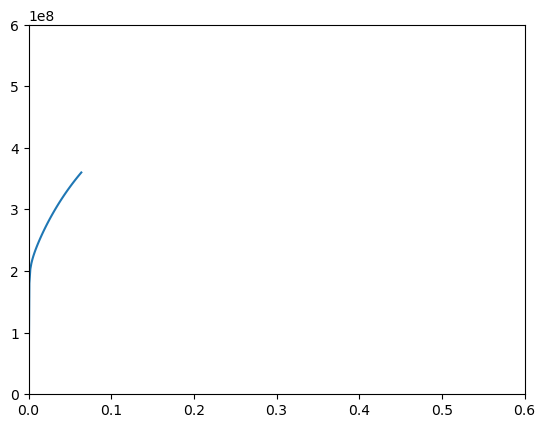

In [25]:
# Plot the result after first rolling simulation
job_rolling.plotStressStrainCurve(0.0,0.60,0.0,6.0e+8) # xmin,xmax, ymin,ymax
plt.show();

Let's upload the result to dsms

In [26]:
# A function to get stress-strain data from a pyiron damask job as dictionary
def get_pyiron_damask_output():
    stress_strain_data = {}
    stress_strain_data['TrueStrain'] = job_rolling.strain_von_Mises.tolist()
    stress_strain_data['TrueStress'] = job_rolling.stress_von_Mises.tolist()
    return stress_strain_data

In [27]:
# After executing this cell, you have to enter your dsms username 
username = getpass()

 ········


In [28]:
# After executing this cell, you have to enter your dsms password
password = getpass()

 ········


In [29]:
# Now we will connect to dsms
dsms = DSMS(host_url="https://stahldigital.materials-data.space",
            username=username,
            password=password)

In [30]:
# Create new Dataset KItem 
item_damask_output = KItem(name='DASMASK output file by Ujjal test',
                           ktype_id=dsms.ktypes.Dataset,
                           annotations = [{'iri':'https://w3id.org/steel/ProcessOntology/TrueStrain',
                                            'name':'TrueStrain',
                                            'namespace':'https://w3id.org/steel/ProcessOntology'},
                                            {'iri':'https://w3id.org/steel/ProcessOntology/TrueStress',
                                            'name':'TrueStress',
                                            'namespace':'https://w3id.org/steel/ProcessOntology'}],
                            #attachments = [{"name": "../resources/Poly_60_16x16x16.vti"}], # in case you have an output vti, you can place it here
                            # linked_kitems = [input_kitem_id]
                           ) 
dsms.commit()

In [31]:
print(item_damask_output.id)

7d308ae2-c7e8-4fc5-a518-d63d8dda3b5f


In [32]:
stress_strain_data = get_pyiron_damask_output()

In [33]:
# fill the kitem with stress-strain data
base_iri = urljoin(str(dsms.config.host_url), str(item_damask_output.id))
download_uri = urljoin(str(dsms.config.host_url), f"api/knowledge/data_api/{item_damask_output.id}")

pipeline = AnnotationPipeline(
    raw_data=stress_strain_data,
    mapping={
        "TrueStrain": {
            "iri": "https://w3id.org/steel/ProcessOntology/TrueStrain",
            "key": "TrueStrain",
            "unit": "http://qudt.org/vocab/unit/NUM",
            "value_location": "TrueStrain"
        },
        "TrueStress": {
            "iri": "https://w3id.org/steel/ProcessOntology/TrueStress",
            "key": "TrueStress",
            "unit": "Pa",
            "value_location": "TrueStress"
        }
        },
        parser=Parser.json,
        config = {
            "base_iri": base_iri,
            "data_download_uri": download_uri,
            "graph_identifier": base_iri
        }
    )

item_damask_output.custom_properties = pipeline.plain_metadata
item_damask_output.hdf5 = pd.DataFrame(pipeline.time_series)
dsms.sparql_interface.subgraph.update(pipeline.graph)
dsms.commit()

/srv/conda/envs/notebook/lib/python3.11/site-packages/data2rdf/models/mapping.py:118: UserWarning: No QUDT Mapping found for unit with symbol `http://qudt.org/vocab/unit/NUM`.
  warnings.warn(


In [34]:
print(dsms[item_damask_output.id].hdf5.TrueStress.convert_to('Pa'))

[6.66851e-05, 180006087.79435137, 203367174.14917058, 212444523.71001965, 219079287.84011072, 224694119.1409012, 229743388.71341962, 234420709.57293886, 238837768.99843875, 243058099.1863127, 247127641.19585067, 251067935.21814173, 254904305.82443127, 258638942.03214306, 262290498.385468, 265862873.39435613, 269361105.8204218, 272789946.66632116, 276153044.7893822, 279454047.1818508, 282695661.59076273, 285880594.8782281, 289010979.52472407, 292088976.9515182, 295116384.8737854, 298095010.8181372, 301026403.7500428, 303912104.198652, 306753455.80104893, 309551792.5739525, 312308284.2305061, 315024100.9469628, 317700260.25204706, 320337796.0160841, 322937590.8982046, 325500568.70097846, 328027508.92157066, 330519274.8932773, 332976604.7833792, 335400373.9470013, 337791339.3266416, 340150417.9662176, 342478367.97619474, 344776093.51258504, 347044285.7698053, 349283783.2652303, 351495183.81007975, 353679262.2371679, 355836537.20723855, 357967725.83512104, 360073264.36491454]


Now, we will do second rolling

In [35]:
# Define parameters for second rolling
reduction_height = 0.1
reduction_speed = 4.5e-2
reduction_outputs = 300
regrid_flag = True
damask_exe = ''

In [36]:
# Run second rolling simulation
job_rolling.executeRolling(reduction_height,
                           reduction_speed,
                           reduction_outputs,
                           regrid_flag,
                           damask_exe
                           )

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.6e-05 1.6e-05 1.6e-05]
regridded RVE size:	 [1.68237764e-05 1.60000000e-05 1.52000000e-05]
initial grid seeds:	 [16 16 16]
regridded grid seeds:	 [18 17 16]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_250.vti
Start the rolling-2 test ...
CMD= DAMASK_grid -g damask_regridded_250.vti -l load_rolling2.yaml -m material.yaml > Rolling-2.log
Rolling-2 test is done !


In [37]:
# Process the result after second rolling simulation
job_rolling.postProcess()

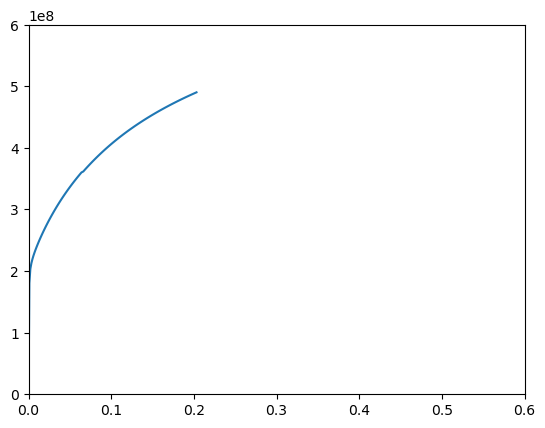

In [38]:
# Plot the result after second rolling simulation
job_rolling.plotStressStrainCurve(0.0,0.60,0.0,6.0e8) # xmin,xmax, ymin,ymax
plt.show();

Third rolling simulation

In [39]:
# Define parameters for third rolling
reduction_height = 0.1
reduction_speed = 4.5e-2
reduction_outputs = 350
regrid_flag = True
damask_exe = ''

In [40]:
# Run third rolling simulation
job_rolling.executeRolling(reduction_height,
                           reduction_speed,
                           reduction_outputs,
                           regrid_flag,
                           damask_exe
                           )

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.68237764e-05 1.60000000e-05 1.52000000e-05]
regridded RVE size:	 [1.97633823e-05 1.60000000e-05 1.29200000e-05]
initial grid seeds:	 [18 17 16]
regridded grid seeds:	 [24 20 16]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_250_regridded_550.vti
Start the rolling-3 test ...
CMD= DAMASK_grid -g damask_regridded_250_regridded_550.vti -l load_rolling3.yaml -m material.yaml > Rolling-3.log
Rolling-3 test is done !


In [41]:
# Process the result after third rolling simulation
job_rolling.postProcess()

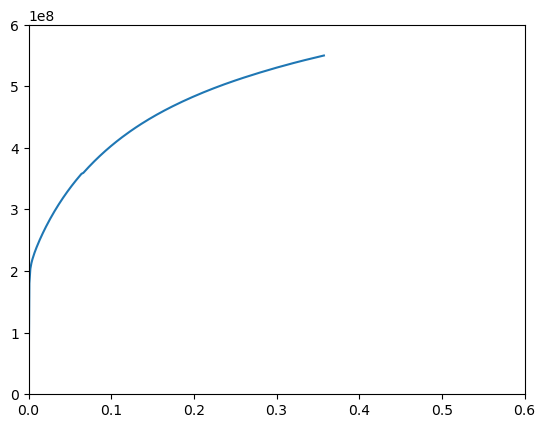

In [42]:
# Plot the result after third rolling simulation
job_rolling.plotStressStrainCurve(0.0,0.60,0.0,6.0e+8) # xmin,xmax, ymin,ymax
plt.show();

Forth rolling simulation

In [43]:
# Define parameters for forth rolling
reduction_height = 0.12
reduction_speed = 4.25e-2
reduction_outputs = 300
regrid_flag = True
damask_exe = ''

In [44]:
# Run forth rolling simulation
job_rolling.executeRolling(reduction_height,
                           reduction_speed,
                           reduction_outputs,
                           regrid_flag,
                           damask_exe
                           )

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.97633823e-05 1.60000000e-05 1.29200000e-05]
regridded RVE size:	 [2.63073724e-05 1.60000000e-05 9.69000000e-06]
initial grid seeds:	 [24 20 16]
regridded grid seeds:	 [44 26 16]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_250_regridded_550_regridded_900.vti
Start the rolling-4 test ...
CMD= DAMASK_grid -g damask_regridded_250_regridded_550_regridded_900.vti -l load_rolling4.yaml -m material.yaml > Rolling-4.log
Rolling-4 test is done !


In [45]:
# Process the result after forth rolling simulation
job_rolling.postProcess()

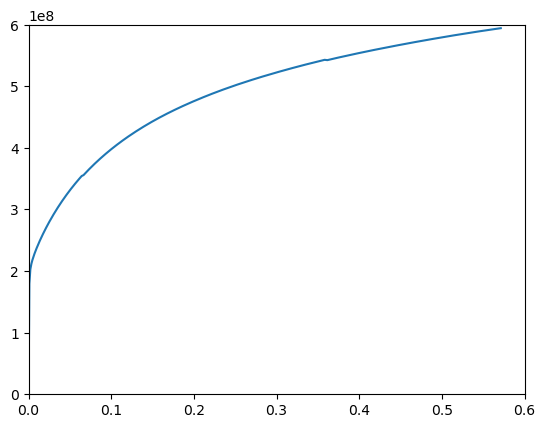

In [46]:
# Plot the result after forth rolling simulation
job_rolling.plotStressStrainCurve(0.0,0.60,0.0,6.0e+8) # xmin,xmax, ymin,ymax
plt.show();